## Initialization
Reference: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


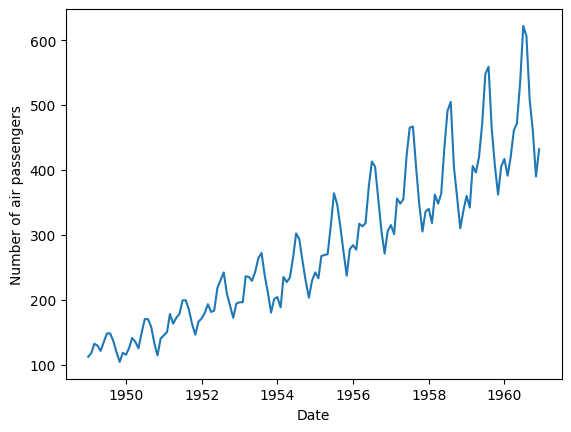

In [4]:
df = pd.read_csv('data/AirPassengers.csv', parse_dates = ['Month'], index_col = ['Month'])
print(df.head())

plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(df)

the data is not stationary as the number of air passengers increases over time. Before applying any statistical model on time series, we want to ensure it's stationary

There are two primary way to determine whether a given time series is stationary.
- **Rolling Statistics**: Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time.
- **Augmented Dickey-Fuller Test**: The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics

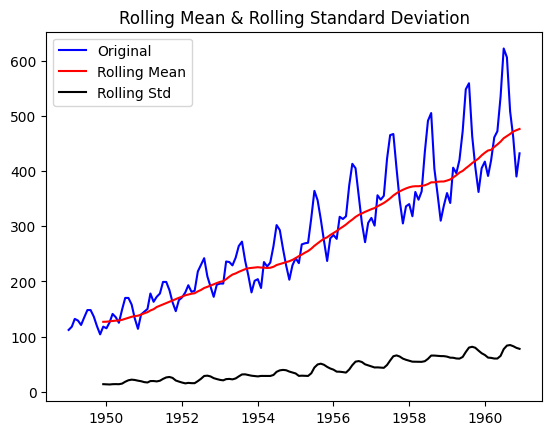

In [5]:
rolling_mean = df.rolling(window=12).mean()
rolling_std  = df.rolling(window=12).std()

plt.plot(df, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

As we can see, the rolling mean and rolling standard deviation increase with time. Thus, we can conclude that the time series is not stationary.

In [7]:
result = adfuller(df['#Passengers'])

print('ADF Statistic: {}'.format(result[0]))
print('p-valueL {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.8153688792060463
p-valueL 0.991880243437641
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


The ADF Statistic is far from the critical values and the p-values is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary

Taking the log of the dependent variable is s simple way of lowering the rate at which rolling mean increases.

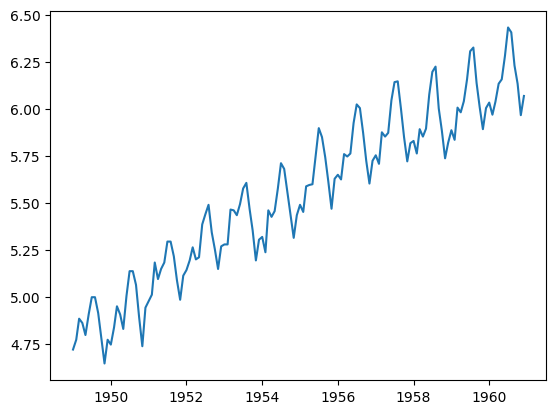

In [8]:
df_log = np.log(df)
plt.plot(df_log)

In [13]:
def get_stationarity(timeseries):
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std  = timeseries.rolling(window=12).std()

    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean     = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std      = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey-Fuller test:
    result = adfuller(timeseries['#Passengers'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key,value))

There are multiple transformations that we can apply to a time series to render it stationary. For instance, we substract the rolling mean.

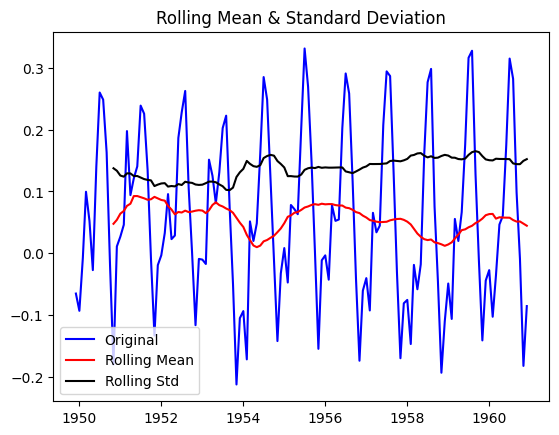

ADF Statistic: -3.1629079913008753
p-value: 0.022234630001242737
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [14]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

get_stationarity(df_log_minus_mean)

As we can see, after substracting the mean, the rolling mean and standard deviation are approximately horizaontal. The p-value is below the threshold of 0.05 and the ADF Statistic is close to the critical values. Therefore, the time series it stationary

Apply exponential decay is another way of transforming a time series such that it is stationary.

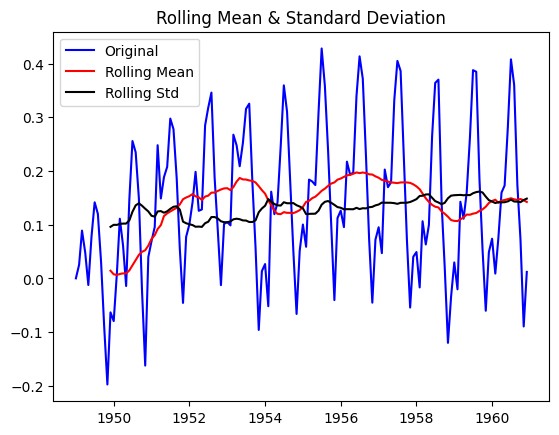

ADF Statistic: -3.6012624201616563
p-value: 0.00573693880151228
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [15]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

get_stationarity(df_log_exp_decay)

Exponential decay performed worse than substracting the rolling mean. However, it is still more stationary than the original

Another method: When appling time shifting, we substract every the point by the one that preceded it.

**null, (x1-x0), (x2-x1), (x3-x2), (x4-x3), ..., (xn-xn-1)**

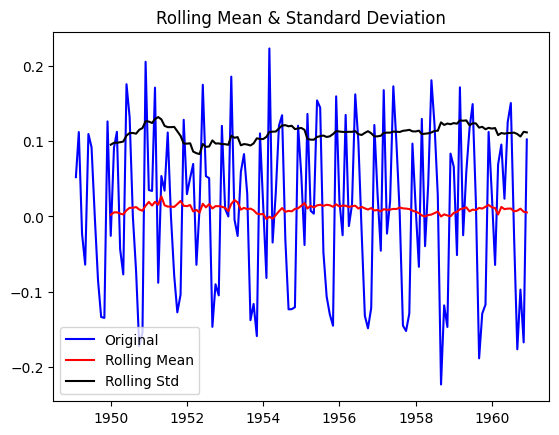

ADF Statistic: -2.717130598388136
p-value: 0.0711205481508582
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


In [16]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)

get_stationarity(df_log_shift)

Time shifting performed worse than substracting the rolling mean. However, it is still more stationary than the original.

## AutoRegressive Model (AR)
it operate under the premise that the past values have an effect on current values. AR Model are commonly used in analyzing nature, economics, and other time-varying processes. As lon as the assumption holds, we can build a linear regression model that attempts to predict value of a dependent variable today, given the values it had on previous days.

$yt = B1yt-1 + B2yt-2 + B3yt-3 + ... + Bpyt-p$


## Moving Average Model (MA)
Assumes the value of the dependent varible on the current day depends on the previous days error terms. The formula can be expressed as: 

$yt = et + a1et-1 + a2et-2 + ... +aqet-1$

## Auto Regressive Moving Average (ARMA)
is simply the combination of the AR and MA models

$yt = B1yt-1 + B2yt-2 + B3yt-3 + ... + Bpyt-p + et + a1et-1 + a2et-2 + ... + aqet-q $

## AutoRegressive Integrated Moving Average Model (ARIMA)

The ARIMA (aka Box-Jenkins) model adds differencing to an ARMA model. Differencing substracts the current value from the previous and can be used to transform a time series into on that's stationary. 
<br>
For example, first-order differencing addresses linear trends, and employs the transformation `yi -yi-1`. 
Second-order differencing addresses quadratic trends and employs a first-order difference of a first-order difference, namely `zi=(yi-yi-1) - (yi-1 - yi-2)`, and so on.

3 integers (p, d, q) are typically used to parametrize ARIMA models.
- *p*: number of autoregressive terms (AR order)
- *d*: number of nonseasonal differences (differencing ord)
- *q*: number of moving-average terms (MA order)

Now, we can create and fit an ARIMA model with AR of order 2, differecing of order 1 and MA of order 2

C:\Users\user\.virtualenvs\Project--uEK5Qj5\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\.virtualenvs\Project--uEK5Qj5\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\.virtualenvs\Project--uEK5Qj5\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


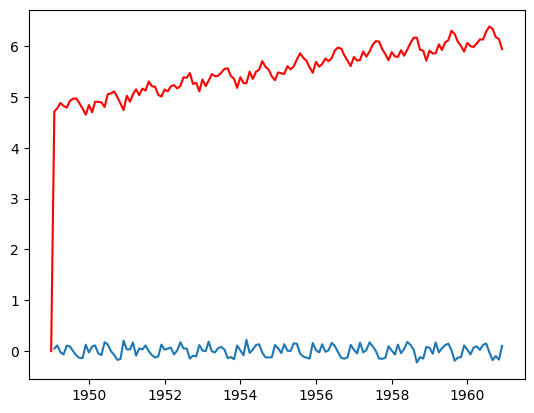

In [20]:
decomposition = seasonal_decompose(df_log)
model = ARIMA(df_log, order=(2,1,2))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')